# SAPIMOUSE


In [1]:
from worldModel import *
from Datasets.sapi2json import *
from Datasets.sapi_data_prepare import *
from Datasets.split_train_test import *
import worldModelDataset as wmd2
import os
import sys
from visu import *
import numpy as np
from tools import *
from loguru import logger

config_path = f"/home/jmartinsaquet/Documents/code/endpoint_prediction/WorldModel/config_sapimouse_continuous.yaml"
model_path = f"/home/jmartinsaquet/Documents/code/endpoint_prediction/checkpoints_new/worldmodel_best_82_error_pixel.pt"


config = load_config(config_path)
# wm = load_wm(model_path, config)
wm = WorldModel.from_config(config, device="cuda:0")
checkpoint = load_best_model(wm=wm, checkpoint_path=model_path)

wm.eval()


2026-02-23 09:55:22.637 | INFO     | tools:load_best_model:43 - Loaded checkpoint from epoch 501
2026-02-23 09:55:22.638 | INFO     | tools:load_best_model:44 - Validation error: 156.2689
2026-02-23 09:55:22.638 | INFO     | tools:load_best_model:45 - Train steps: 26052


WorldModel(
  (act_fn): SiLU()
  (dynamics_model): RSSM(
    (rnn): GRUCell(64, 128)
    (prior_net): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): SiLU()
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): SiLU()
      (6): Linear(in_features=512, out_features=512, bias=True)
      (7): SiLU()
      (8): Linear(in_features=512, out_features=128, bias=True)
    )
    (posterior_net): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): SiLU()
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): SiLU()
      (6): Linear(in_features=512, out_features=512, bias=True)
      (7): SiLU()
      (8): Linear(in_features=512, out_features=128, bias=True)
    )
  )
  (encoder): Encoder(
    (act_fn): SiLU()
    (mlp):

In [2]:
full_ds = False # true to get the full dataset of sapi mouse without having the 200hz echantillonnage
if full_ds:
    # train_ds = wmd2.generate_sapimouse_dataset("/home/jmartinsaquet/Documents/code/endpoint_prediction/Datasets/sapimouse/segmented_ds_click.json",window_size=16, stride=None, normalize=normalize, include_velocity=False, filter_users='user67',)
    train_ds = wmd2.generate_sapimouse_dataset("/home/jmartinsaquet/Documents/code/endpoint_prediction/Datasets/sapimouse/segmented_ds_click.json", window_size=64, stride=None, normalize=normalize, include_velocity=False, filter_users=None, num_padding_zeros=100)

    val_idx = np.random.choice(len(train_ds.trajectories), 6, replace=False).tolist()
    logger.info(val_idx)
    dataset = train_ds
else:
    data = pd.read_json("/home/jmartinsaquet/Documents/code/endpoint_prediction/Datasets/sapiuser62treated.json")
    # train_data, test_data = wmd2.user_split_train_test_sapimouse(data, train = 0.8, test = 0.2)
    data.index[0]
    trajs = []
    for ind in data.index:
        x = data.at[ind, 'x']
        y = data.at[ind, 'y']
        t = np.array((x,y), dtype=float)
        # print(t.shape)
        trajs.append(t)

    N = 1000  # your threshold
    # 1. Keep rows where the trajectory is LONG ENOUGH (max timestamp > N)
    data = data[data["timestamp"].apply(lambda ts: max(ts) < N)]


    dataset = wmd2.df_to_trajectory_dataset(data, window_size=64, stride=None, normalize=True, num_endpoint_padding=0, include_timestamp=False)


Converted 198 valid trajectories from DataFrame


2026-02-23 09:57:26.924 | INFO     | __main__:<module>:7 - [179, 28, 70, 164, 10, 163]
2026-02-23 09:57:27.498 | INFO     | __main__:<module>:9 - results keys: dict_keys([179, 28, 70, 164, 10, 163])


(<Figure size 1200x600 with 1 Axes>,
 <Figure size 2000x1300 with 6 Axes>,
 <Figure size 2000x1300 with 6 Axes>)

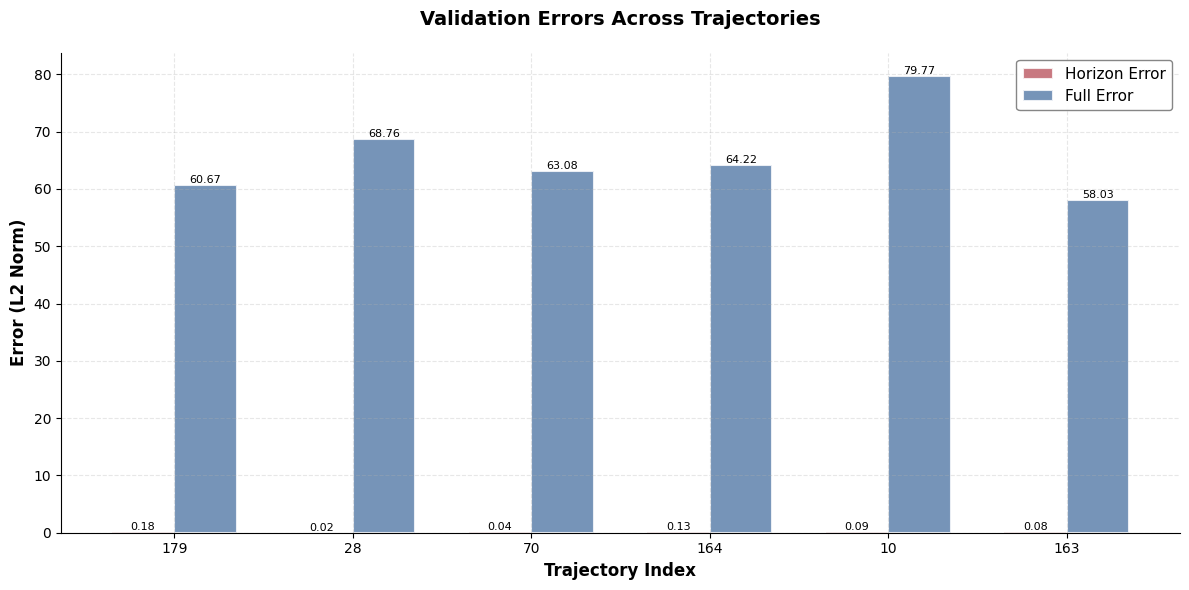

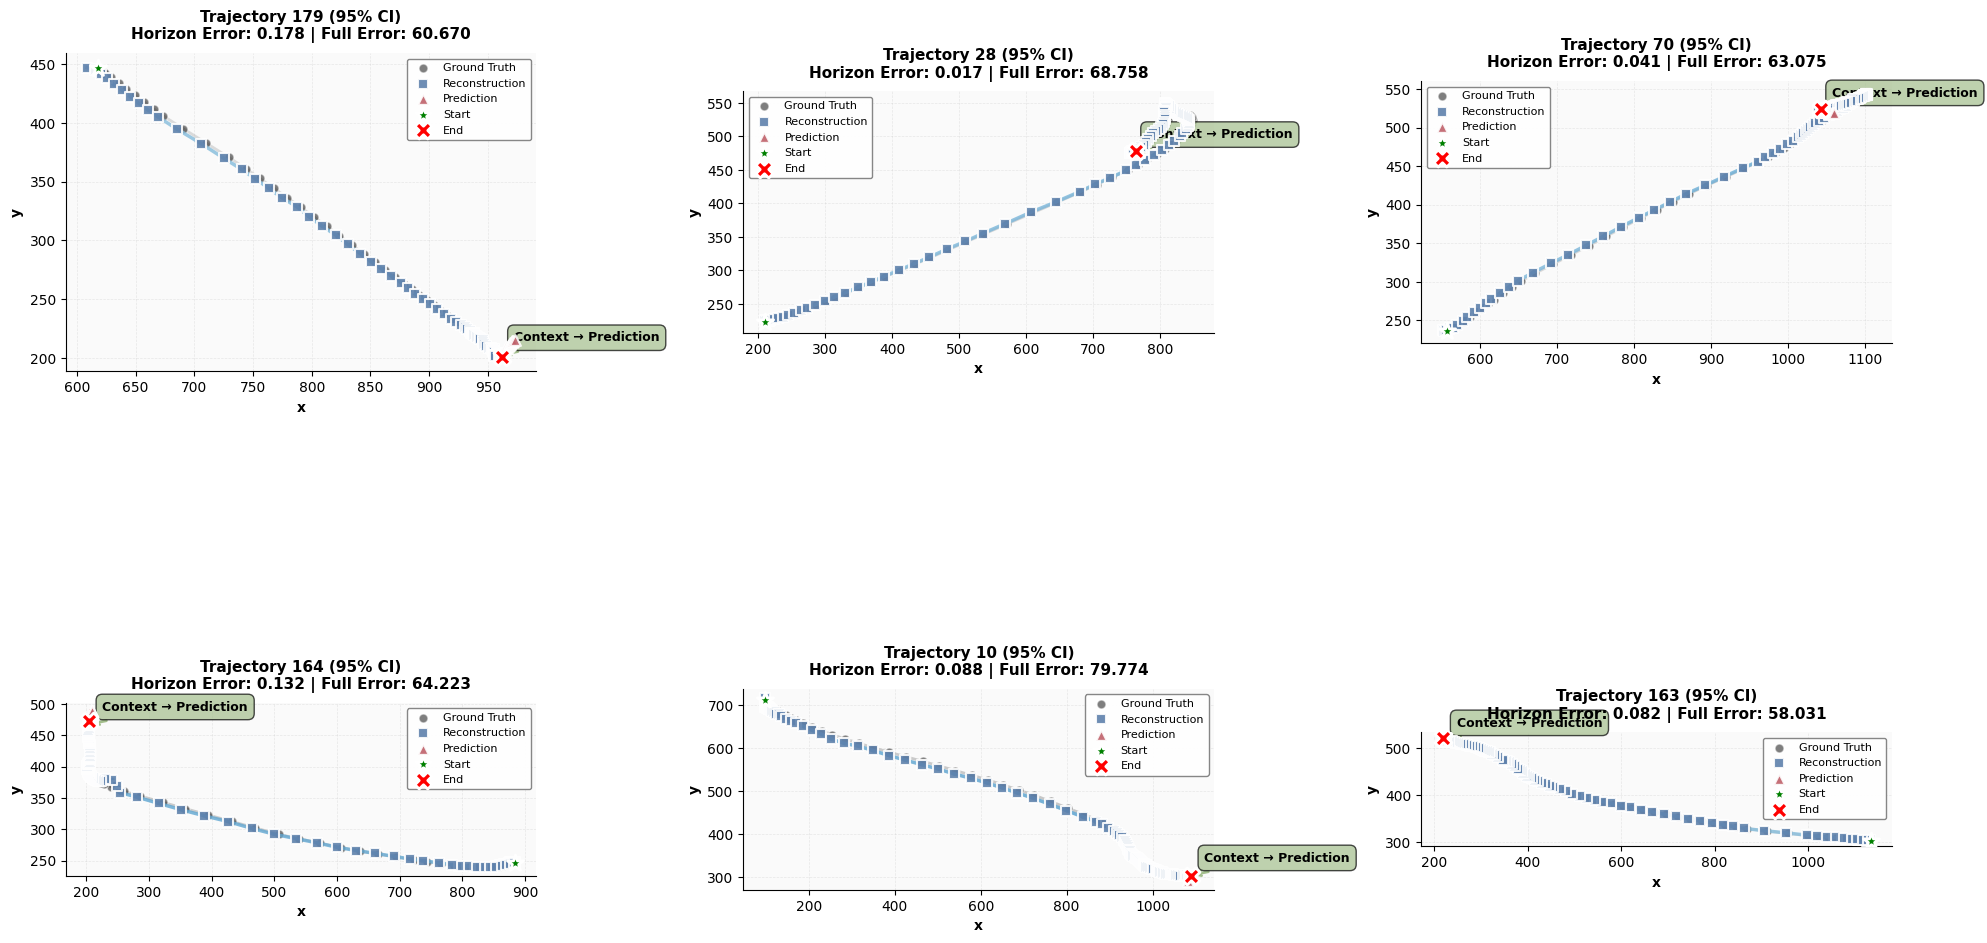

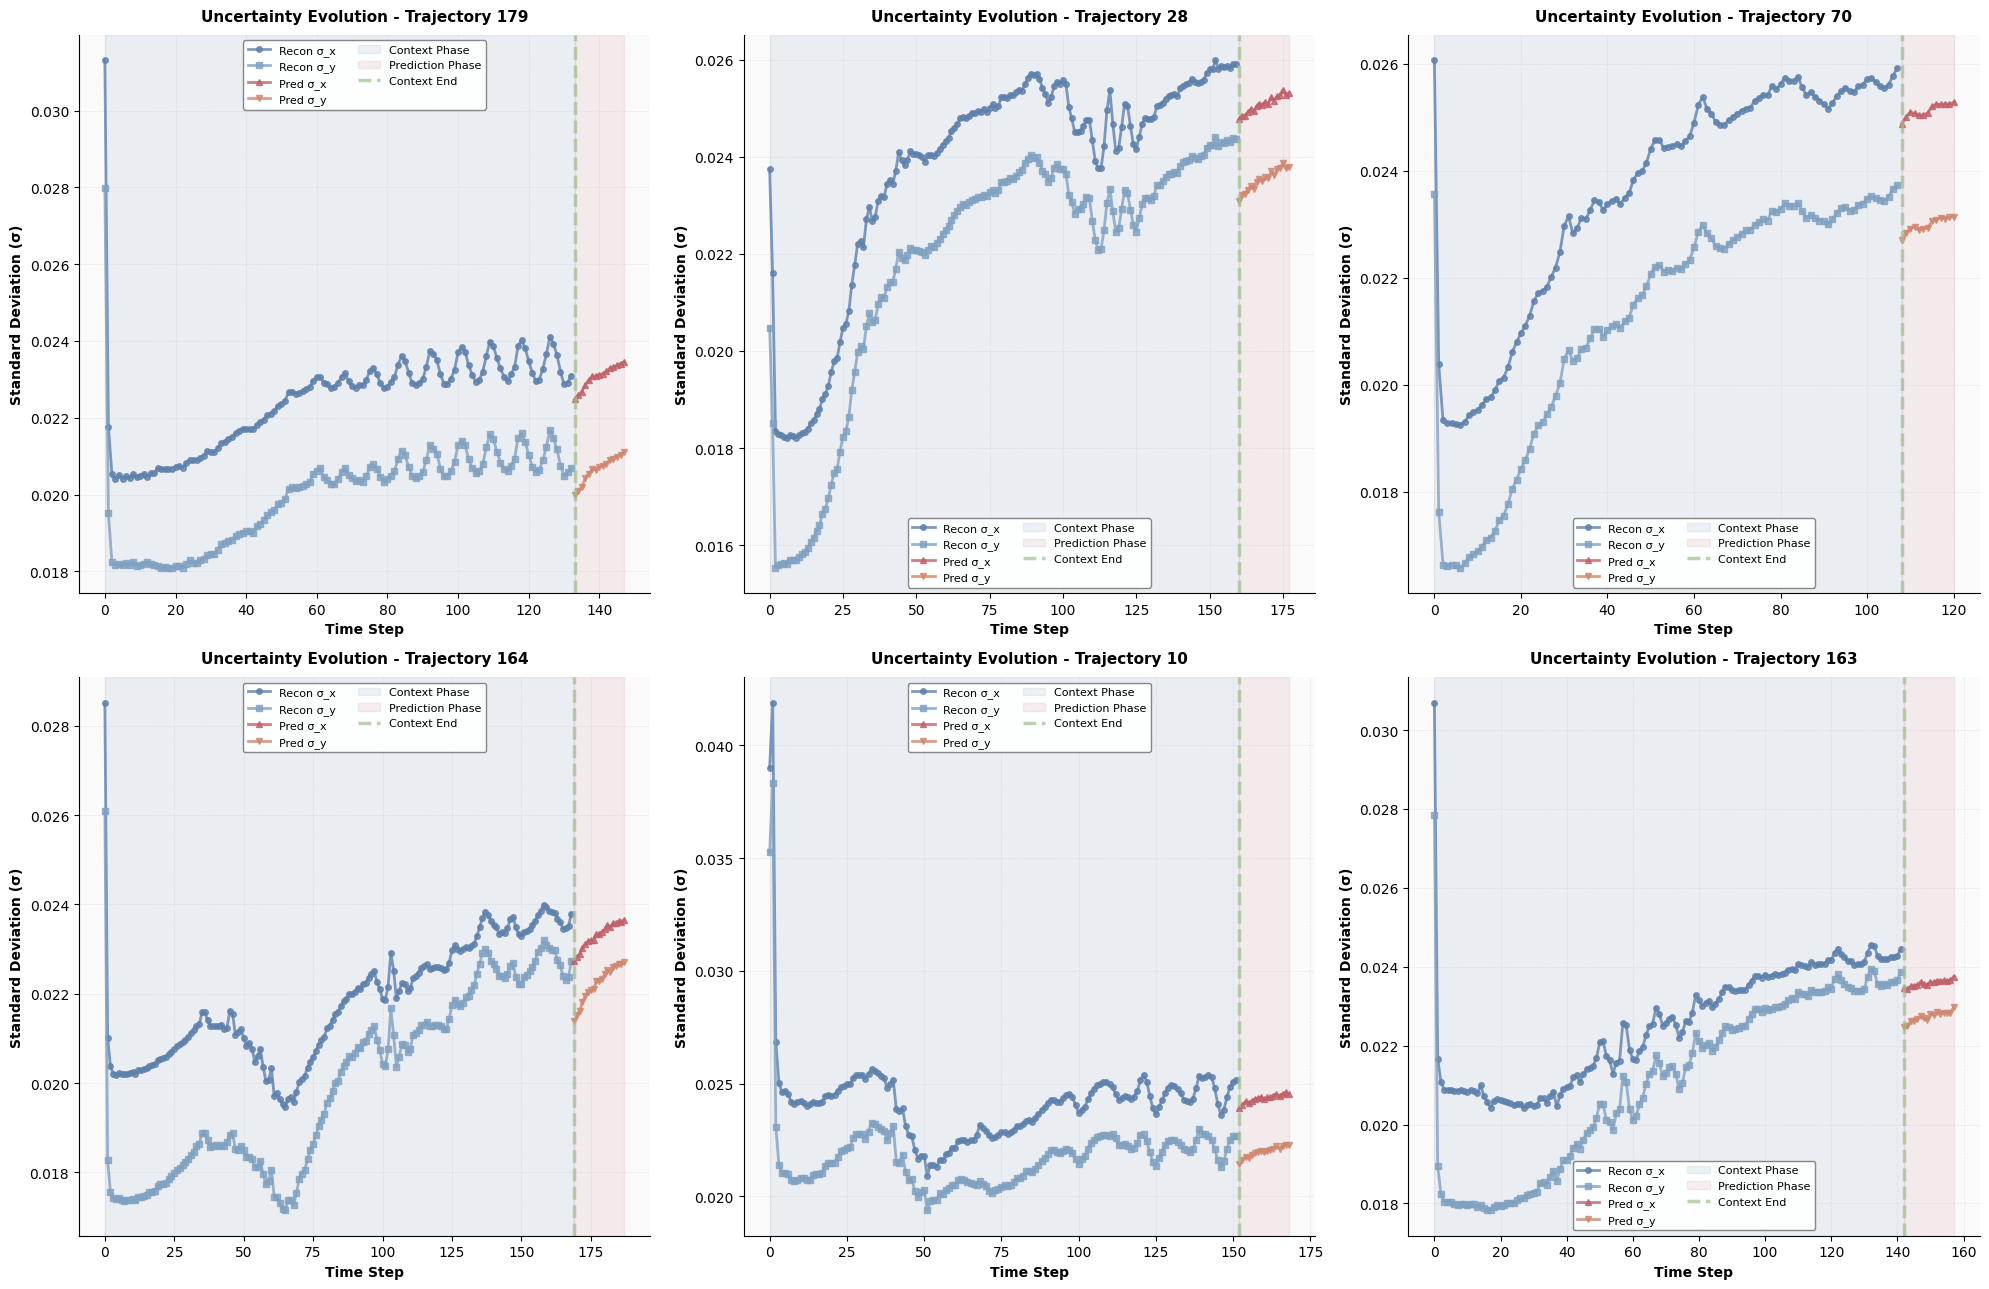

In [6]:
%matplotlib inline
# visualize the trajectories
context_ratio = 0.90
horizon = 10

val_idx = np.random.choice(len(dataset.trajectories), 6, replace=False).tolist()
logger.info(val_idx)
results, summary = validate_multiple_trajectories(wm, dataset, trajectory_indices=val_idx, context_ratio=context_ratio, horizon=horizon, normalize=config["normalize"])
logger.info(f"results keys: {results.keys()}")
plot_multiple_trajectories(results, summary, save_dir=None)

/home/jmartinsaquet/Documents/code/endpoint_prediction/WorldModel/visu.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


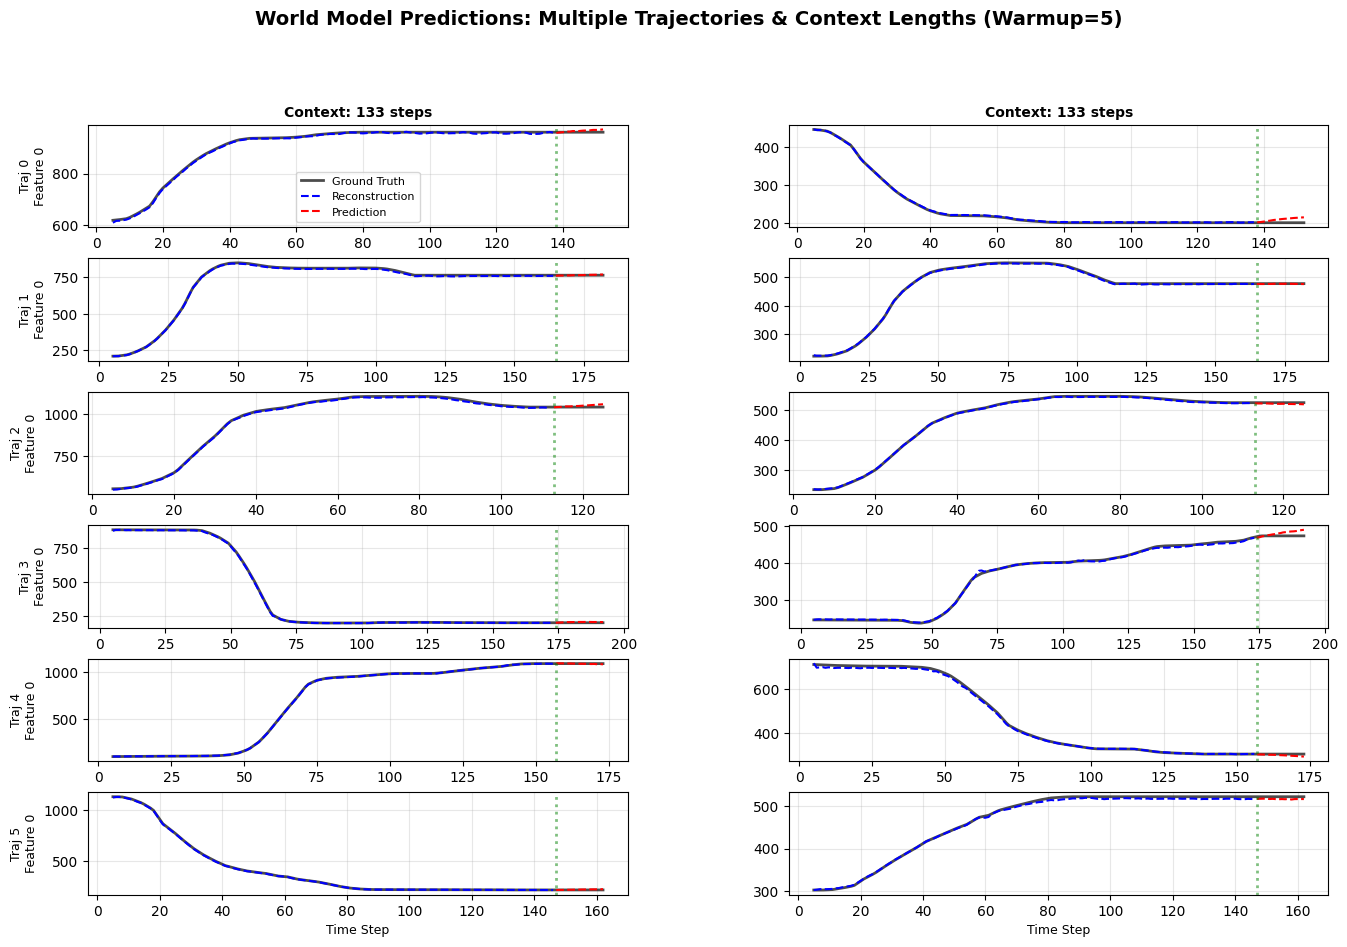

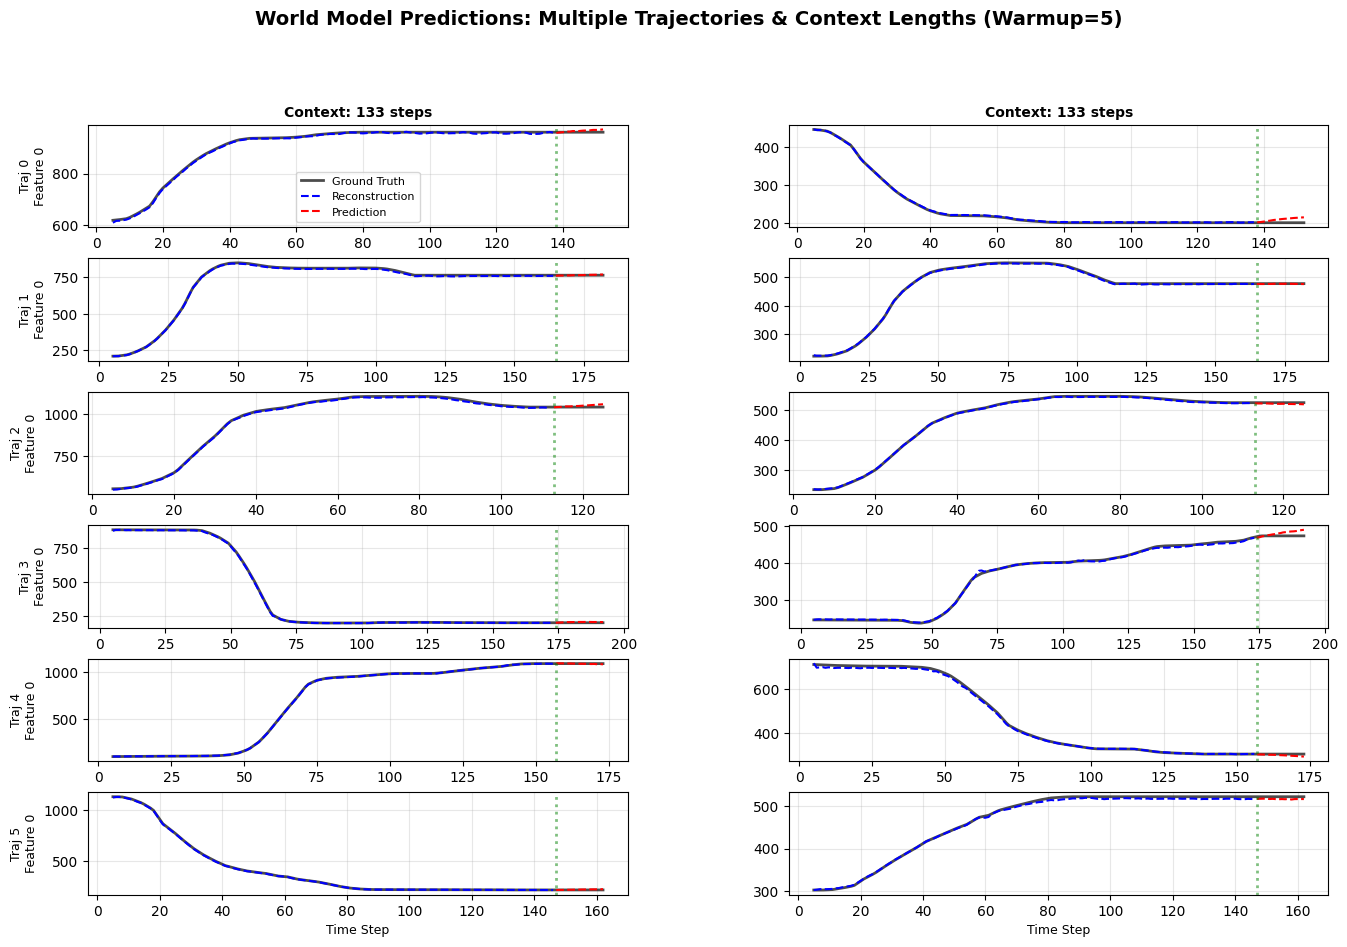

In [7]:
# 1D traj visualisation
trajs = [results[keys] for keys in results.keys()]

visualize_multi_trajectory_predictions(trajs)

2026-02-23 09:58:37.602 | INFO     | __main__:<module>:20 - Mean error: 16.7468 ± 15.7604


[0] gt: [1077.0002   481.99994], pred: [1076.9966   485.07028], error: 3.0703
[1] gt: [372.      344.00003], pred: [354.1843 340.9785], error: 18.0701
[2] gt: [586. 418.], pred: [561.8741  411.36218], error: 25.0224
[3] gt: [897.9999  477.00012], pred: [886.76685 471.5207 ], error: 12.4982
[4] gt: [728.0001 319.    ], pred: [738.85547 316.18488], error: 11.2144
[5] gt: [417.      235.99997], pred: [424.01868 234.58379], error: 7.1601
[6] gt: [1431.0004  390.    ], pred: [1436.5077  378.8163], error: 12.4662
[7] gt: [1449.       300.00003], pred: [1423.7439   300.90216], error: 25.2722
[8] gt: [185.      242.00003], pred: [179.84322 239.41109], error: 5.7702
[9] gt: [1159.2356  281.5883], pred: [1065.0718  302.6287], error: 96.4859
[10] gt: [1090.0002  303.    ], pred: [1098.3253   289.96973], error: 15.4627
[11] gt: [1138.0002   172.00002], pred: [1100.0833   171.85687], error: 37.9173
[12] gt: [1299.0002   392.99994], pred: [1253.387    385.32846], error: 46.2539
[13] gt: [987.5001 64

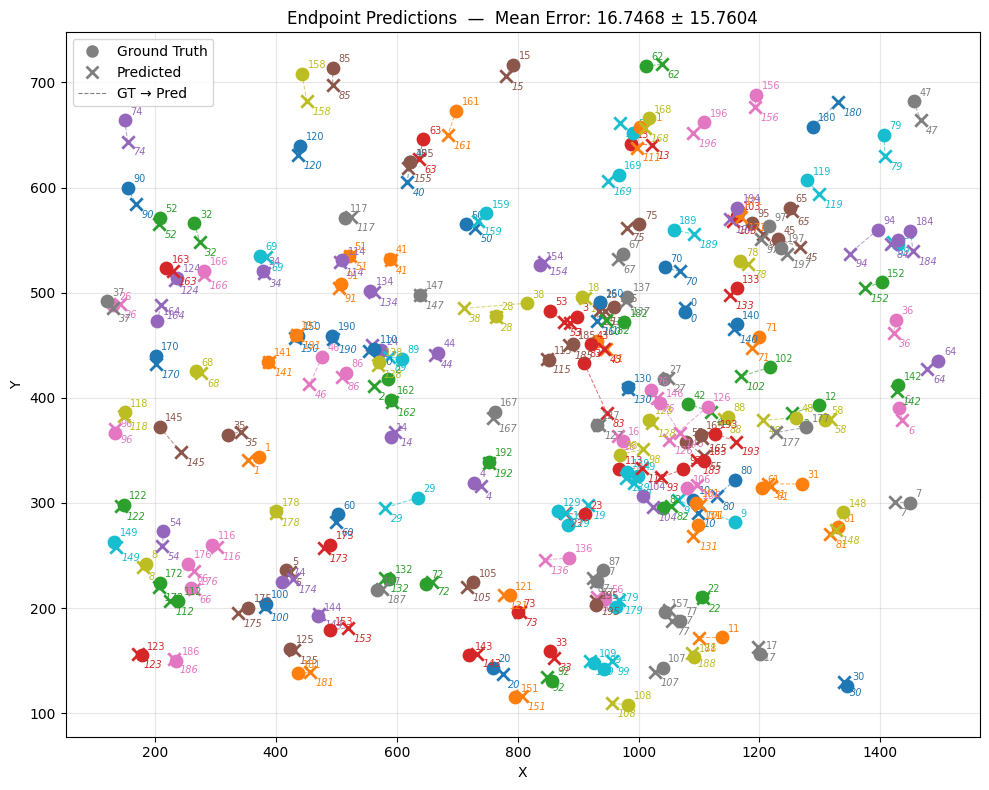

In [9]:
val_idx = np.arange(len(dataset.trajectories)).tolist()

results, summary = validate_multiple_trajectories(
    wm, dataset, trajectory_indices=val_idx, 
    context_ratio=context_ratio, horizon=horizon, normalize=config["normalize"]
)

err = []
endpoint_gt = []
endpoint_pred = []

for k in results.keys():
    gt = results[k]["ground_truth"][-1]
    pred = results[k]["predictions"][-1]
    endpoint_gt.append(gt)
    endpoint_pred.append(pred)
    err.append(np.linalg.norm(gt - pred))
    print(f"[{k}] gt: {gt}, pred: {pred}, error: {err[-1]:.4f}")

logger.info(f"Mean error: {np.mean(err):.4f} ± {np.std(err):.4f}")

endpoint_gt = np.array(endpoint_gt)
endpoint_pred = np.array(endpoint_pred)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 8))

keys = list(results.keys())
cmap = plt.cm.tab10
colors = [cmap(i % 10) for i in range(len(keys))]

for i, (gt, pred, color, k) in enumerate(zip(endpoint_gt, endpoint_pred, colors, keys)):
    # Connect GT and pred with a dashed line
    ax.plot([gt[0], pred[0]], [gt[1], pred[1]], color=color, linestyle="--", linewidth=0.8, alpha=0.6)
    # Plot GT and pred points
    ax.scatter(*gt,   color=color, marker="o", s=80, zorder=3)
    ax.scatter(*pred, color=color, marker="x", s=80, zorder=3, linewidths=2)
    # Label with trajectory index
    ax.annotate(str(k), xy=gt,   xytext=(4,  4), textcoords="offset points", fontsize=7, color=color)
    ax.annotate(str(k), xy=pred, xytext=(4, -10), textcoords="offset points", fontsize=7, color=color, style="italic")

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker="o", color="gray", linestyle="None", markersize=8, label="Ground Truth"),
    Line2D([0], [0], marker="x", color="gray", linestyle="None", markersize=8, markeredgewidth=2, label="Predicted"),
    Line2D([0], [0], color="gray", linestyle="--", linewidth=0.8, label="GT → Pred"),
]
ax.legend(handles=legend_elements, loc="best")

ax.set_title(f"Endpoint Predictions  —  Mean Error: {np.mean(err):.4f} ± {np.std(err):.4f}")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import worldModelDataset as wmd2

def plot_sapimouse_trajectories(data, num_trajectories=10, figsize=(12, 8)):
    """
    Plot x, y trajectories from the SapiMouse DataFrame.
    
    Args:
        data: DataFrame with list-valued x, y, timestamp columns
        num_trajectories: Number of trajectories to plot
        figsize: Figure size
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    colors = plt.cm.rainbow(np.linspace(0, 1, num_trajectories))

    for i, (idx, row) in enumerate(data.iterrows()):
        if i >= num_trajectories:
            break

        # Extract lists from the row
        x   = np.array(row["x"])
        y   = np.array(row["y"])
        ts  = np.array(row["timestamp"])

        label = f"Traj {idx} ({row['actiontype']})"
        color = colors[i]

        # --- Plot 1: X,Y path ---
        axes[0].plot(x, y, "-o", color=color, markersize=2, linewidth=1.5, label=label, alpha=0.8)
        axes[0].plot(x[0],  y[0],  "^", color=color, markersize=8)   # start
        axes[0].plot(x[-1], y[-1], "s", color=color, markersize=8)   # end

        # --- Plot 2: X and Y over time ---
        axes[1].plot(ts, x[:-1], "-",  color=color, linewidth=1.5, label=f"x traj {idx}")
        axes[1].plot(ts, y[:-1], "--", color=color, linewidth=1.5, label=f"y traj {idx}")

    axes[0].set_xlabel("X (pixels)")
    axes[0].set_ylabel("Y (pixels)")
    axes[0].set_title("Mouse Trajectories (X vs Y)")
    axes[0].invert_yaxis()   # screen coords: y increases downward
    axes[0].legend(fontsize=7)
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel("Timestamp (ms)")
    axes[1].set_ylabel("Position (pixels)")
    axes[1].set_title("X and Y over Time")
    axes[1].legend(fontsize=7)
    axes[1].grid(True, alpha=0.3)

    plt.suptitle("SapiMouse Trajectories", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()
    return fig

# Usage
# fig = plot_sapimouse_trajectories(data, num_trajectories=15)